In [1]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

sys.path.append("../models/")
from huang_ferrell_1996 import *
from bhalla_iyengar_1999 import *
from kholodenko_2000 import *
from levchenko_2000 import *
from brightman_fell_2000 import *
from schoeberl_2002 import *
from hatakeyama_2003 import *
from hornberg_2005 import *
from birtwistle_2007 import *
from orton_2009 import *
from vonKriegsheim_2009 import *
from shin_2014 import *
from ryu_2015 import *
from kochanczyk_2017 import *
from dessauges_2022 import *

jax.config.update("jax_enable_x64", True)
%matplotlib inline

sys.path.insert(0, '../')
from utils import *

rng = np.random.default_rng(seed=1234)

# On Martini set the visible GPU to the 2080Ti
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


/home/nlinden/mambaforge/envs/pymc5_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Real Data (Santos et al)

In [2]:
# Haung and Ferrell 1996
HF_1996_idata, HF_1996_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/huang_ferrell_1996/huang_ferrell_1996_smc_samples.json')
HF_1996_post = np.load('../../../results/MAPK/param_est/real_data/huang_ferrell_1996/huang_ferrell_1996_posterior_predictive_samples.npy')

# Kholodenko 2000
K_2000_idata, K_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kholodenko_2000/kholodenko_2000_smc_samples.json')
K_2000_post = np.load('../../../results/MAPK/param_est/real_data/kholodenko_2000/kholodenko_2000_posterior_predictive_samples.npy')

# Levchenko 2000
L_2000_idata, L_2000_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/levchenko_2000/levchenko_2000_smc_samples.json')
L_2000_post = np.load('../../../results/MAPK/param_est/real_data/levchenko_2000/levchenko_2000_posterior_predictive_samples.npy')
# Hatakeyama 2003
HK_2003_idata, HK_2003_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hatakeyama_2003/hatakeyama_2003_smc_samples.json')
HK_2003_post = np.load('../../../results/MAPK/param_est/real_data/hatakeyama_2003/hatakeyama_2003_posterior_predictive_samples.npy')
# Hornberg 2005
# H_2005_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/hornberg_2005/hornberg_2005_smc_samples.json') # TODO: add once smc is done
# H_2005_post = np.load('../../../results/MAPK/param_est/real_data/hornberg_2005/hornberg_2005_posterior_predictive_samples.npy')
# Birtwistle 2007
# B_2007_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/birtwistle_2007/birtwistle_2007_smc_samples.json') # TODO: add once smc is done
# B_2007_post = np.load('../../../results/MAPK/param_est/real_data/birtwistle_2007/birtwistle_2007_posterior_predictive_samples.npy')
# Orton 2009
O_2009_idata, O_2009_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/orton_2009/orton_2009_smc_samples.json')
O_2009_post = np.load('../../../results/MAPK/param_est/real_data/orton_2009/orton_2009_posterior_predictive_samples.npy')
# von Kreigsheim 2009
# vK_2009_idata, ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009/von_kreigsheim_2009_smc_samples.json') # TODO: add once smc is done
# vK_2009_post = np.load('../../../results/MAPK/param_est/real_data/von_kreigsheim_2009/von_kreigsheim_2009_posterior_predictive_samples.npy')
# Shin 2014
S_2014_idata, S_2014_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/shin_2014/shin_2014_smc_samples.json')
S_2014_post = np.load('../../../results/MAPK/param_est/real_data/shin_2014/shin_2014_posterior_predictive_samples.npy')
# Ryu 2015
R_2015_idata, R_2015_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/ryu_2015/ryu_2015_smc_samples.json')
R_2015_post = np.load('../../../results/MAPK/param_est/real_data/ryu_2015/ryu_2015_posterior_predictive_samples.npy')
# Kochańczyk 2017
K_2017_idata, K_2017_ss = load_smc_samples_to_idata('../../../results/MAPK/param_est/real_data/kochanczyk_2017/kochanczyk_2017_smc_samples.json')
K_2017_post = np.load('../../../results/MAPK/param_est/real_data/kochanczyk_2017/kochanczyk_2017_posterior_predictive_samples.npy')

model_names = ['huang_ferrell_1996', 'kholodenko_2000', 'levchenko_2000', 'hatakeyama_2003','orton_2009', 'shin_2014', 'ryu_2015', 'kochanczyk_2017']
display_names = ['Huang Ferrell 1996','Kholodenko 2000', 'Levchenko 2000', 'Katakeyama 2003','Orton 2009', 'Shin 2014', 'Ryu 2015', 'Kochańczyk 2017']

# gather posterior samples
posterior_samples = [HF_1996_post, K_2000_post, L_2000_post, HK_2003_post, O_2009_post, S_2014_post, R_2015_post, K_2017_post]
shin_id = 5
# shin has 16000 so downsample to 4000
idxs = rng.choice(np.arange(16000), size=4000, replace=False)
posterior_samples[shin_id] = S_2014_post[idxs]

# get data
inputs, data = load_data('../../../results/MAPK/Santos_2007_stim_resp_data.csv')

# set up a color palette
colors = sns.color_palette('pastel', n_colors=len(model_names)+2)

# sns.color_palette("husl", len(model_names)+2)

(-0.35186975534622406, 1.3705192867935097)
(-0.08703879254422399, 1.494049540874455)
(-0.40736612667023187, 1.5093048817210177)
(7.745996376990207e-05, 35.293858931387774)


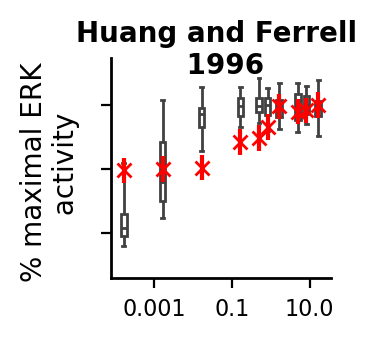

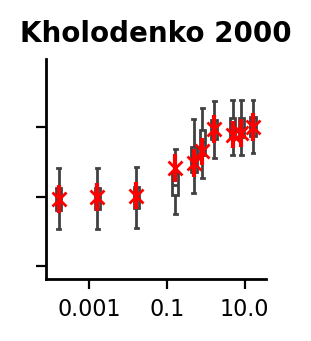

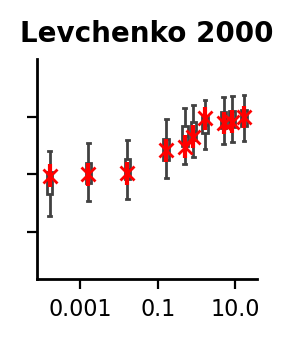

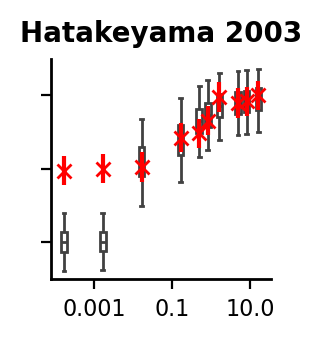

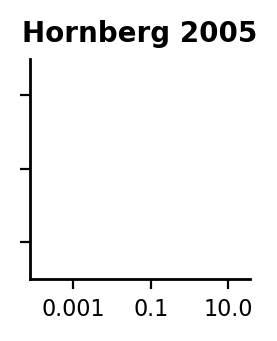

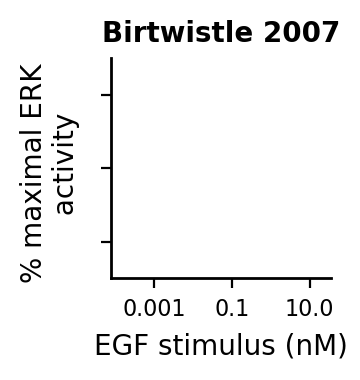

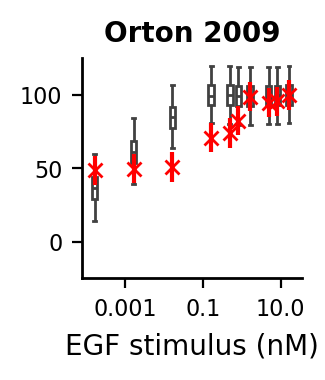

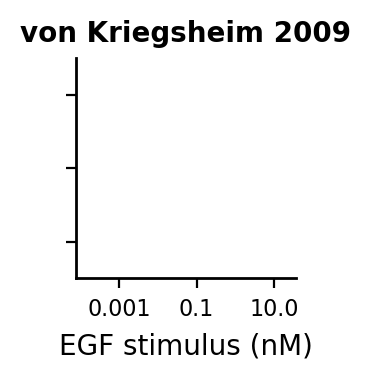

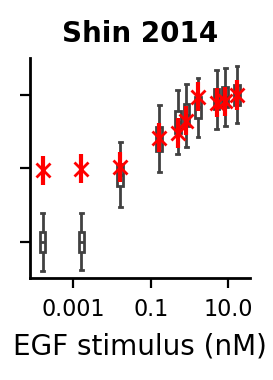

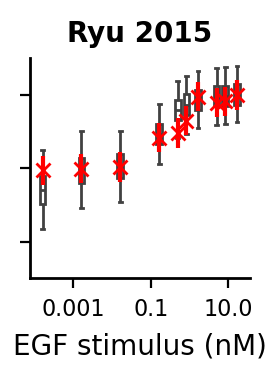

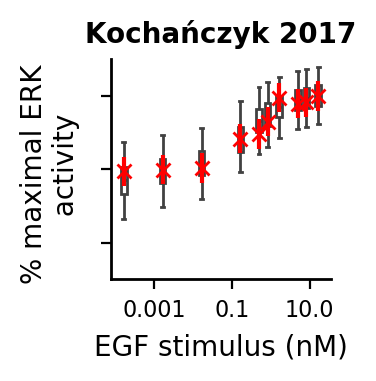

In [3]:
# TODO: Haung and Ferrell 1996
fig, ax = plot_stimulus_response_curve_pretty(HF_1996_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)

print(ax.get_ylim())
ax.set_yticks([0, 0.5, 1.0])
ax.set_xscale('log')
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Huang and Ferrell \n 1996', fontsize=10.0, y=0.85)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/HF_1996_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve_pretty(K_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
print(ax.get_ylim())
ax.set_yticks([0, 0.5, 1.0])
ax.set_xscale('log')
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_title('Kholodenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/K_2000_posterior_predictive.pdf', transparent=True)


fig, ax = plot_stimulus_response_curve_pretty(L_2000_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
# ax.set_ylim([-0.25, 1.25])
print(ax.get_ylim())
ax.set_yticks([0, 0.5, 1.0])
ax.set_xscale('log')
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xticklabels(ax.get_xticks(), fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Levchenko 2000', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/L_2000_posterior_predictive.pdf', transparent=True)

print(ax.get_xlim())
fig, ax = plot_stimulus_response_curve_pretty(HK_2003_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_xlabel('')
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hatakeyama 2003', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/HK_2003_posterior_predictive.pdf', transparent=True)

# TODO: Hornberg 2005
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
# ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Hornberg 2005', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/H_2005_posterior_predictive.pdf', transparent=True)

# TODO: Birtwistle 2007
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774507658])
ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
# ax.set_ylabel('')
ax.set_title('Birtwistle 2007', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/B_2007_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve_pretty(O_2009_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Orton 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/O_2009_posterior_predictive.pdf', transparent=True)

# TODO: von Kriegsheim 2009
fig, ax = get_sized_fig_ax(1.1, 1.1)
ax.set_xscale('log')
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel('EGF stimulus (nM)', fontsize=10.0)
# ax.set_ylabel('% maximal ERK \n activity', fontsize=10.0)
ax.set_xlim([7.745996376990207e-05, 35.293858931387774])
ax.set_ylabel('')
ax.set_title('von Kriegsheim 2009', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/VK_2009_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve_pretty(S_2014_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Shin 2014', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/S_2014_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve_pretty(R_2015_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')
ax.set_title('Ryu 2015', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/R_2015_posterior_predictive.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve_pretty(K_2017_post, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK \n activity', box_color='w', data_color='r',
                                 data_std=0.1, width=1.1, height=1.1, data_marker_size=5.0, scatter_marker_size=0)
ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([])
ax.set_xticks([1e-3, 1e-1, 1e1])
ax.set_xticklabels([1e-3, 1e-1, 1e1], fontsize=8)
ax.set_xlabel(ax.get_xlabel(), fontsize=10.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
# ax.set_ylabel('')
ax.set_title('Kochańczyk 2017', fontsize=10.0)
fig.savefig('../../../figures/MAPK/param_est/Santos_data/K_2017_posterior_predictive.pdf', transparent=True)

### Run Trajectory sims (sustained EGF input)

In [4]:
data_savedir = '../../../results/MAPK/param_est/real_data/'
fig_savedir = '../../../figures/MAPK/param_est/Santos_data/'
input_idxs = np.arange(0,10)
# Huang and Ferrell 1996
HF_1996_traj, HF_1996_converted_times, HF_1996_params = get_trajectories(
    'huang_ferrell_1996', HF_1996_idata, 40, 240, 1, 100, 
    'E1', 1.0, ['MAPK_PP','MAPK_PP_MAPKPase'], inputs[input_idxs], data_savedir)

# # Kholodenko 2000
# K_2000_traj, K_2000_converted_times, K_2000_params = get_trajectories(
#     'kholodenko_2000', K_2000_idata, 400, 14400, 1/60, 100, 
#     'Input', 1.0, ['MAPK_PP'], inputs[input_idxs], data_savedir)

# # Levchenko 2000
# L_2000_traj, L_2000_converted_times, L_2000_params = get_trajectories(
#     'levchenko_2000', L_2000_idata, 400, 14400, 1/60, 100, 'RAFact', 0.001, ['MAPKstarstar'], inputs[input_idxs], data_savedir)

# # Hatakeyama 2003
# HK_2003_traj, HK_2003_converted_times, HK_2003_params = get_trajectories(
#     'hatakeyama_2003', HK_2003_idata, 400, 14400, 1/60, 100, 'HRG', 1, ['ERKPP'], inputs[input_idxs], data_savedir)

# # # Hornberg 2005
# # H_2005_traj, H_2005_converted_times, H_2005_params = get_trajectories(
# #     'hornberg_2005', H_2005_idata, 400, 14400, 1/60, 100, 'c1', 0.000000001, ['c59','c83'], inputs[input_idxs], data_savedir)

# # # Birtwistle 2007
# # B_2007_traj, B_2007_converted_times, B_2007_params = get_trajectories(
# #     'birtwistle_2007', B_2007_idata, 400, 14400, 1/60, 100, 'E', 1.0, 
# #     ['ERKstar','ERKstar_ERKpase'], inputs[input_idxs], data_savedir)

# # Orton 2009
# O_2009_traj, O_2009_converted_times, O_2009_params = get_trajectories(
#     'orton_2009', O_2009_idata, 400, 240, 1, 100,'EGF', 602214, ['ErkActive'],
#     inputs[input_idxs], data_savedir)

# # VonKriegsheim 2009
# # TODO: run when inference is complete
# # VK_2009_traj, VK_2009_traj_norm, VK_2009_converted_times = get_trajectories(
# #     'vonKriegsheim_2009', VK_2009_idata, 400, 240, 1, 100, 'EGF', 6.048, 
# #     ['ppERK','ppERK_15','ppERKn'],inputs[input_idxs], data_savedir)

# # Shin 2014
# S_2014_traj, S_2014_converted_times, S_2014_params = get_trajectories(
#     'shin_2014', S_2014_idata, 400, 240, 1, 100, 'EGF',  0.001, ['pp_ERK'],
#     inputs[input_idxs], data_savedir)

# # Ryu 2015
# R_2015_traj, R_2015_converted_times, R_2015_params = get_trajectories(
#     'ryu_2015', R_2015_idata, 400, 240, 1, 100, 'EGF', 6.048, ['ERK_star'], inputs[input_idxs], data_savedir)

# # Kochanczyk 2017
# K_2017_traj,  K_2017_converted_times, K_2017_params = get_trajectories(
#     'kochanczyk_2017', K_2017_idata, 400, 14400, 1/60, 100, 'EGF', 6048, ['ERKSPP'],
#     inputs[input_idxs], data_savedir)

I0000 00:00:1702483971.046264 3369352 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


### Plot trajectories

In [ ]:
# Haung and Ferrell 1996
HF_1996_conv = np.tile(np.max(np.array([np.max(HF_1996_traj[key], axis=1) for key in HF_1996_traj.keys()]), axis=0), (100,1)).T
HF_1996_traj_norm = normalize_trajs(HF_1996_traj, HF_1996_conv, 'haung_ferrell_1996', data_savedir)
make_traj_plots('HF_1996', 'Haung and Ferrell 1996', inputs[input_idxs], 40, HF_1996_traj_norm, HF_1996_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
plt.close('all')

# # Kholodenko 2000
# K_2000_conv = np.tile(np.max(np.array([np.max(K_2000_traj[key], axis=1) for key in K_2000_traj.keys()]), axis=0), (100,1)).T
# K_2000_traj_norm = normalize_trajs(K_2000_traj, K_2000_conv, 'kholodenko_2000', data_savedir)
# make_traj_plots('K_2000', 'Kholodenko 2000', inputs[input_idxs], 400, K_2000_traj_norm, K_2000_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # Levchenko 2000
# L_2000_conv = np.tile(np.max(np.array([np.max(L_2000_traj[key], axis=1) for key in L_2000_traj.keys()]), axis=0), (100,1)).T
# L_2000_traj_norm = normalize_trajs(L_2000_traj, L_2000_conv, 'levchenko_2000', data_savedir)
# make_traj_plots('L_2000', 'Levchenko 2000', inputs[input_idxs], 400, L_2000_traj_norm, L_2000_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # Hatakeyama 2003
# HK_2003_conv = np.tile(np.max(np.array([np.max(HK_2003_traj[key], axis=1) for key in HK_2003_traj.keys()]), axis=0), (100,1)).T
# HK_2003_traj_norm = normalize_trajs(HK_2003_traj, HK_2003_conv, 'hatakeyama_2003', data_savedir)
# make_traj_plots('HK_2003', 'Hatakeyama 2003', inputs[input_idxs], 400,  HK_2003_traj_norm, HK_2003_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # # Hornberg 2005
# # H_2005_conv = np.tile(np.max(np.array([np.max(H_2005_traj[key], axis=1) for key in H_2005_traj.keys()]), axis=0), (100,1)).T
# # H_2005_traj_norm = normalize_trajs(H_2005_traj, H_2005_conv, 'hornberg_2005', data_savedir)
# # make_traj_plots('H_2005', 'Hornberg 2005', inputs[input_idxs], 400,H_2005_traj_norm, H_2005_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# #plt.close('all')

# # # Birtwistle 2007
# # B_2007_conv = np.tile(np.max(np.array([np.max(B_2007_traj[key], axis=1) for key in B_2007_traj.keys()]), axis=0), (100,1)).T
# # B_2007_traj_norm = normalize_trajs(B_2007_traj, B_2007_conv, 'birtwistle_2007', data_savedir)
# # make_traj_plots('B_2007', 'Birtwistle 2007', inputs[input_idxs], 400,  B_2007_traj_norm, B_2007_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# #plt.close('all')

# # Orton 2009
# O_2009_conv = np.tile(np.max(np.array([np.max(O_2009_traj[key], axis=1) for key in O_2009_traj.keys()]), axis=0), (100,1)).T
# O_2009_traj_norm = normalize_trajs(O_2009_traj, O_2009_conv, 'orton_2009', data_savedir)
# make_traj_plots('O_2009', 'Orton 2009', inputs[input_idxs], 400, O_2009_traj_norm, O_2009_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # # vonKriegsheim 2009
# ## VK_2009_conv = np.array(0.0311267292018+0.9688732707982)
# ## make_traj_plots('VK_2009', 'vonKriegsheim 2009', inputs[input_idxs], 400, VK_2009_traj, VK_2009_converted_times, fig_savedir, , [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # Shin 2014
# S_2014_conv = np.tile(np.max(np.array([np.max(S_2014_traj[key], axis=1) for key in S_2014_traj.keys()]), axis=0), (100,1)).T
# S_2014_traj_norm = normalize_trajs(S_2014_traj, S_2014_conv, 'shin_2014', data_savedir)
# make_traj_plots('S_2014', 'Shin 2014', inputs[input_idxs], 400, S_2014_traj_norm, S_2014_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# #plt.close('all')

# # Ryu 2015
# R_2015_conv = np.tile(np.max(np.array([np.max(R_2015_traj[key], axis=1) for key in R_2015_traj.keys()]), axis=0), (100,1)).T
# R_2015_traj_norm = normalize_trajs(R_2015_traj, R_2015_conv, 'ryu_2015', data_savedir)
# make_traj_plots('R_2015', 'Ryu 2015', inputs[input_idxs], 400, R_2015_traj_norm, R_2015_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

# # Kochanczyk 2017
# K_2017_conv = np.tile(np.max(np.array([np.max(K_2017_traj[key], axis=1) for key in K_2017_traj.keys()]), axis=0), (100,1)).T
# K_2017_traj_norm = normalize_trajs(K_2017_traj, K_2017_conv, 'kochanczyk_2017', data_savedir)
# make_traj_plots('K_2017', 'Kochanczyk 2017', inputs[input_idxs], 400, K_2017_traj_norm, K_2017_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, traj_plot_height=0.6)
# plt.close('all')

/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fon

### Re-run but now with a transient EGF input

In [ ]:
data_savedir = '../../../results/MAPK/param_est/real_data/'
fig_savedir = '../../../figures/MAPK/param_est/Santos_data/'
input_idxs = np.arange(0,11)
# Huang and Ferrell 1996
HF_1996_traj, HF_1996_converted_times, HF_1996_params = get_trajectories(
    'huang_ferrell_1996', HF_1996_idata, 40, 240, 1, 100, 
    'E1', 1.0, ['MAPK_PP','MAPK_PP_MAPKPase'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Kholodenko 2000
# K_2000_traj, K_2000_converted_times, K_2000_params = get_trajectories(
#     'kholodenko_2000', K_2000_idata, 400, 14400, 1/60, 100, 
#     'Input', 1.0, ['MAPK_PP'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Levchenko 2000
# L_2000_traj, L_2000_converted_times, L_2000_params = get_trajectories(
#     'levchenko_2000', L_2000_idata, 400, 14400, 1/60, 100, 'RAFact', 0.001, ['MAPKstarstar'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Hatakeyama 2003
# HK_2003_traj, HK_2003_converted_times, HK_2003_params = get_trajectories(
#     'hatakeyama_2003', HK_2003_idata, 400, 14400, 1/60, 100, 'HRG', 1, ['ERKPP'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # # Hornberg 2005
# # H_2005_traj, H_2005_converted_times, H_2005_params = get_trajectories(
# #     'hornberg_2005', H_2005_idata, 400, 14400, 1/60, 100, 'c1', 0.000000001, ['c59','c83'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # # Birtwistle 2007
# # B_2007_traj, B_2007_converted_times, B_2007_params = get_trajectories(
# #     'birtwistle_2007', B_2007_idata, 400, 14400, 1/60, 100, 'E', 1.0, 
# #     ['ERKstar','ERKstar_ERKpase'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Orton 2009
# O_2009_traj, O_2009_converted_times, O_2009_params = get_trajectories(
#     'orton_2009', O_2009_idata, 400, 240, 1, 100,'EGF', 602214, ['ErkActive'],
#     inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # VonKriegsheim 2009
# # TODO: run when inference is complete
# # VK_2009_traj, VK_2009_traj_norm, VK_2009_converted_times = get_trajectories(
# #     'vonKriegsheim_2009', VK_2009_idata, 400, 240, 1, 100, 'EGF', 6.048, 
# #     ['ppERK','ppERK_15','ppERKn'],inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Shin 2014
# S_2014_traj, S_2014_converted_times, S_2014_params = get_trajectories(
#     'shin_2014', S_2014_idata, 400, 240, 1, 100, 'EGF',  0.001, ['pp_ERK'],
#     inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Ryu 2015
# R_2015_traj, R_2015_converted_times, R_2015_params = get_trajectories(
#     'ryu_2015', R_2015_idata, 400, 240, 1, 100, 'EGF', 6.048, ['ERK_star'], inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

# # Kochanczyk 2017
# K_2017_traj,  K_2017_converted_times, K_2017_params = get_trajectories(
#     'kochanczyk_2017', K_2017_idata, 400, 14400, 1/60, 100, 'EGF', 6048, ['ERKSPP'],
#     inputs[input_idxs], data_savedir, stim_type='True', additional_naming='transient_')

Transient plots

/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fon

/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:769: UserWarning: FixedFormatter should only be used together with FixedLocator
  s_ax.set_yticklabels([0.0, 0.5, 1.0], fontsize=8.0)
/scratch/nlinden/multimodel-inference/src/MAPK/param_est/../utils.py:811: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0.0, 0.5, 1.0], fonts

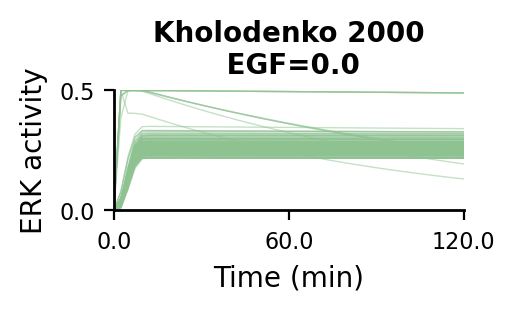

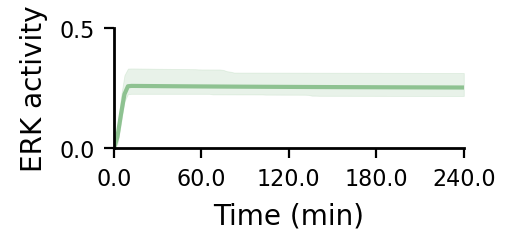

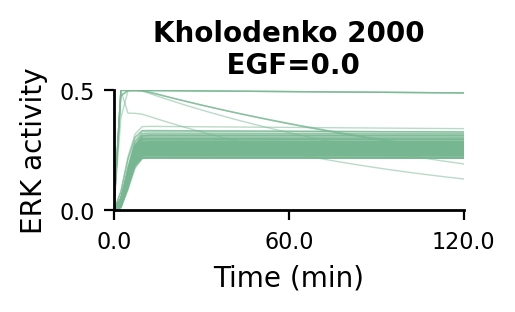

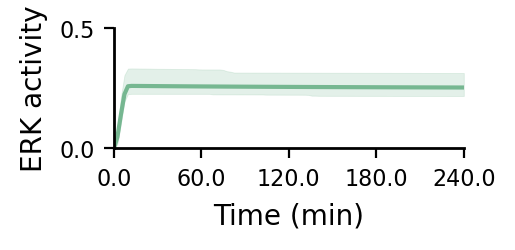

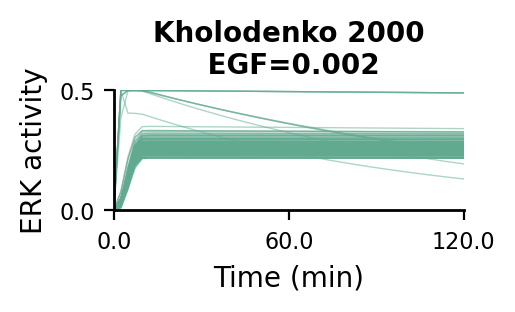

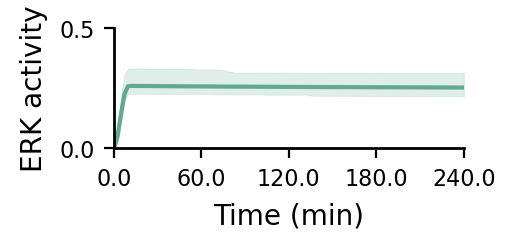

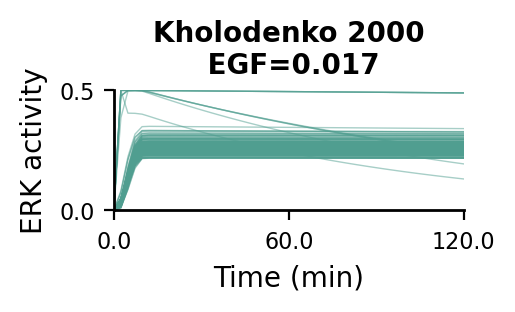

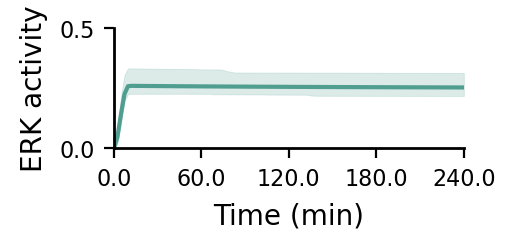

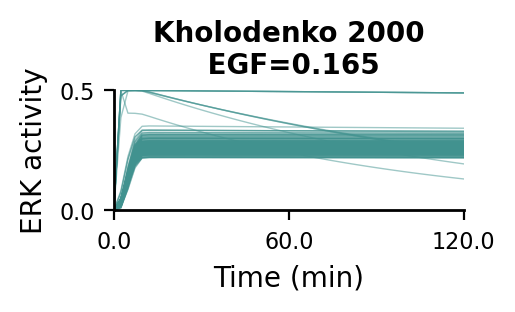

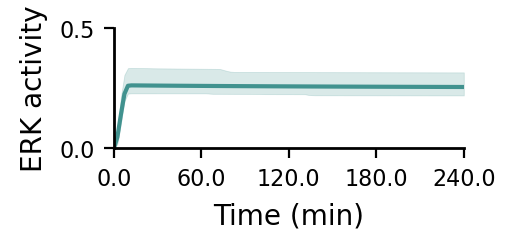

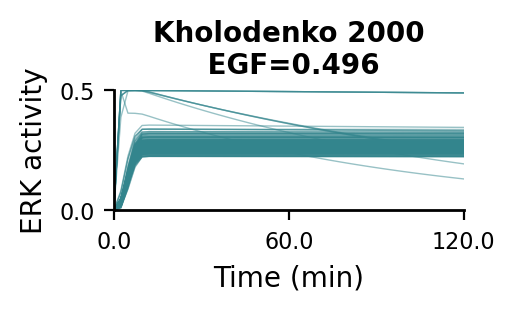

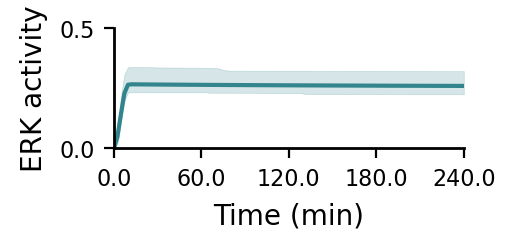

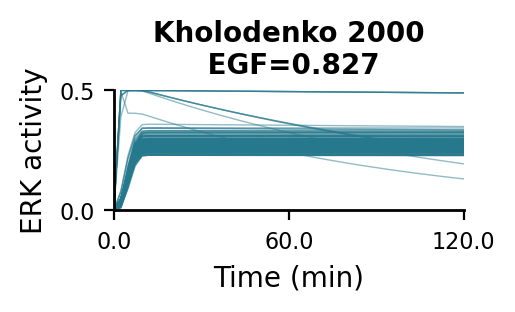

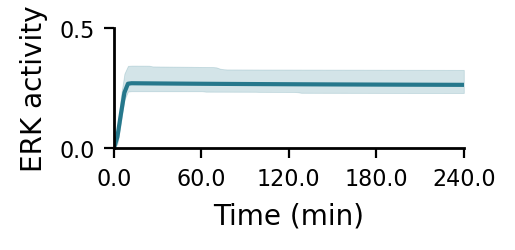

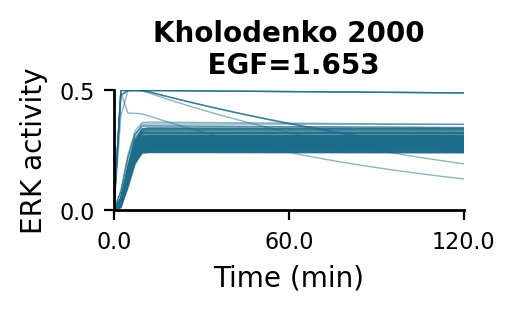

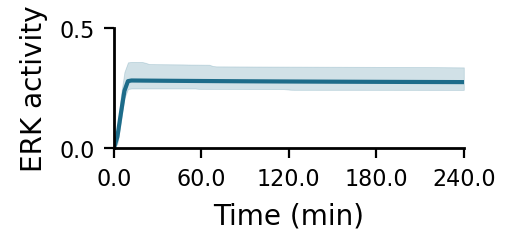

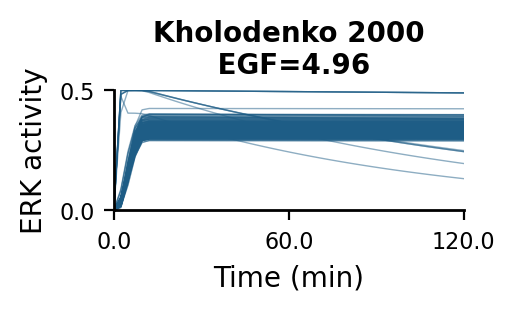

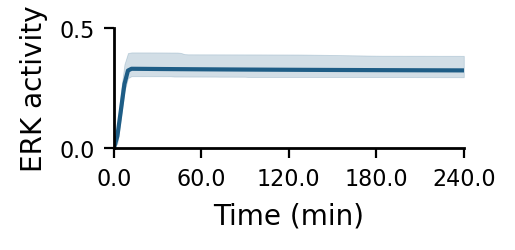

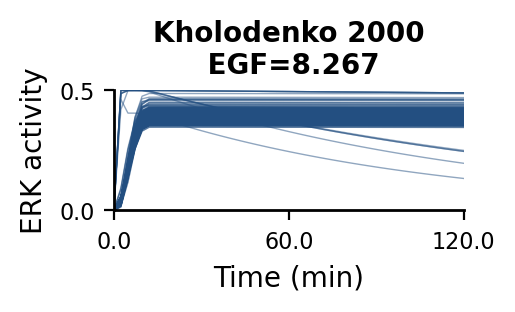

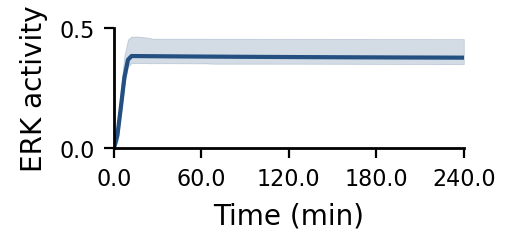

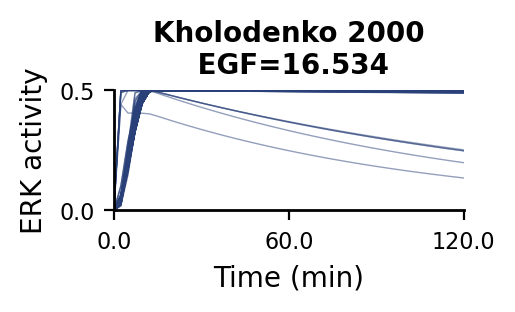

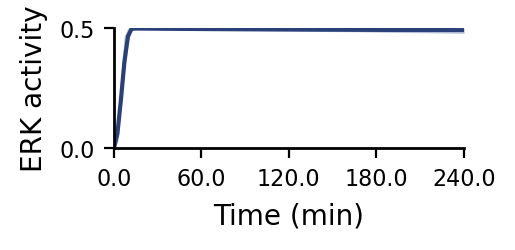

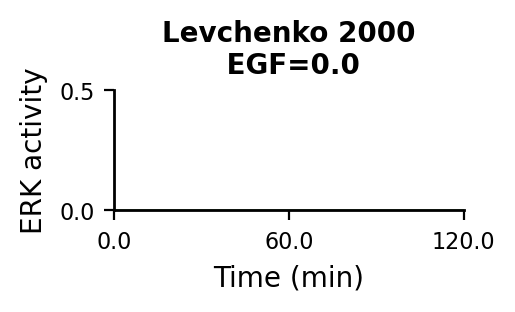

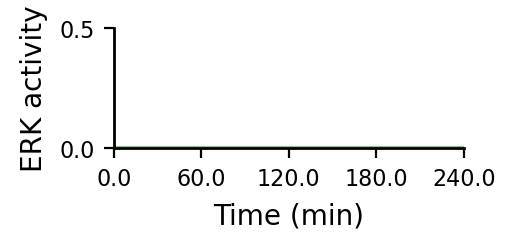

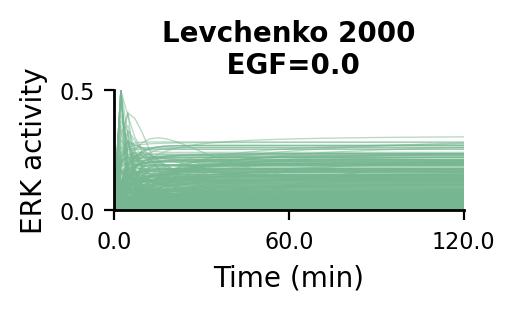

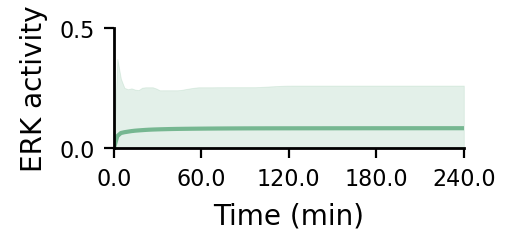

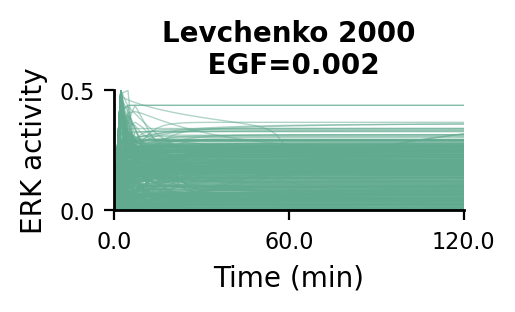

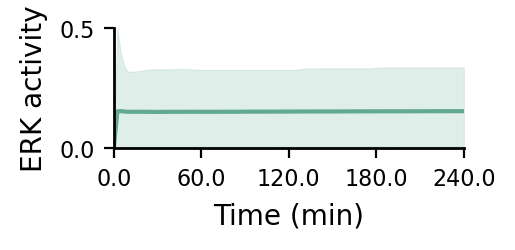

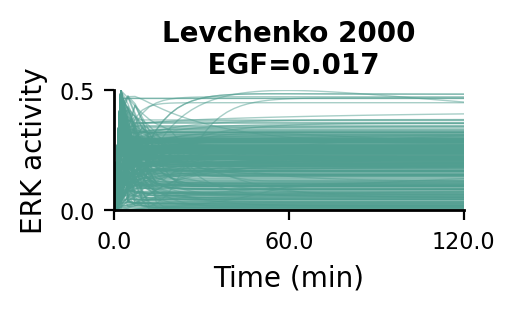

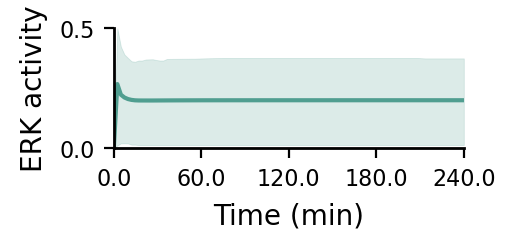

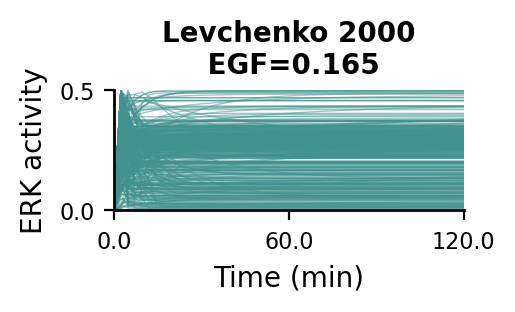

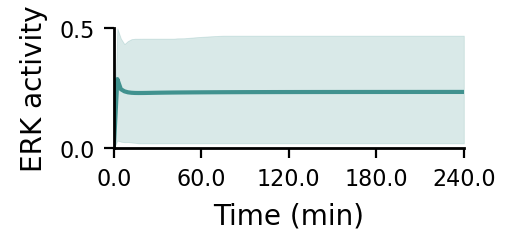

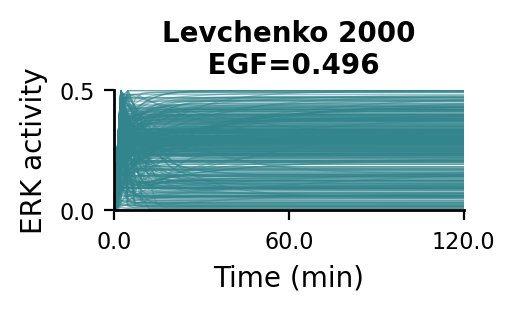

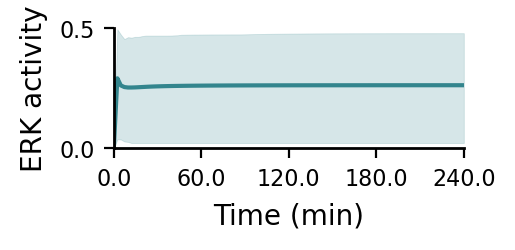

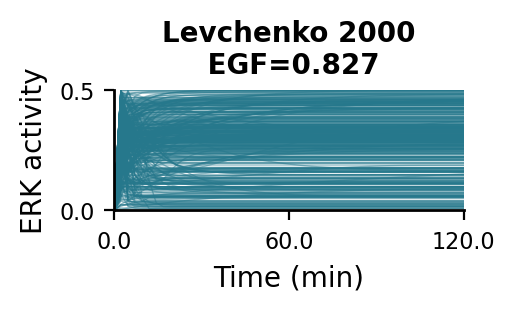

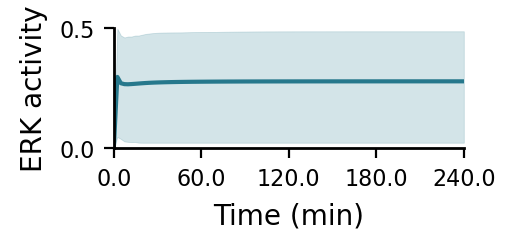

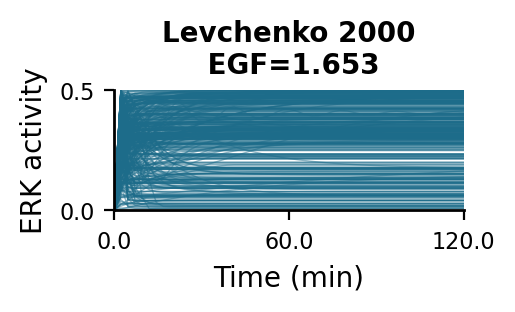

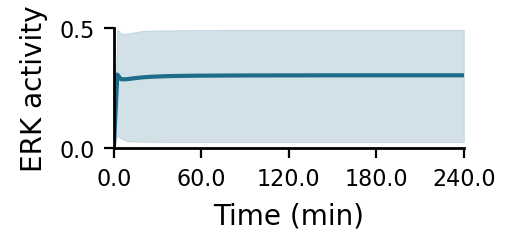

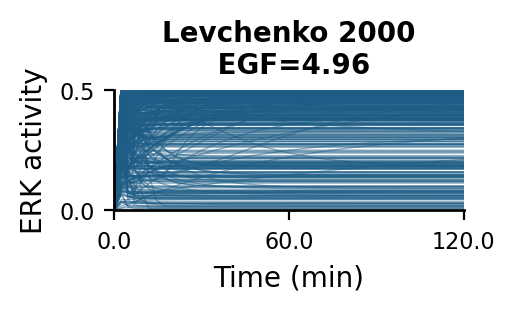

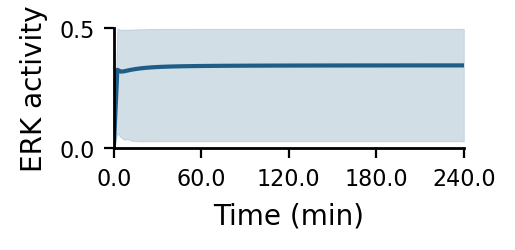

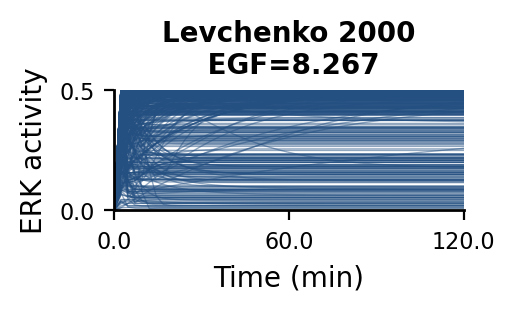

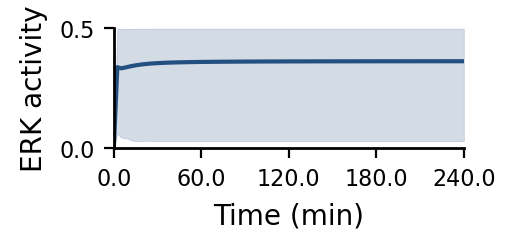

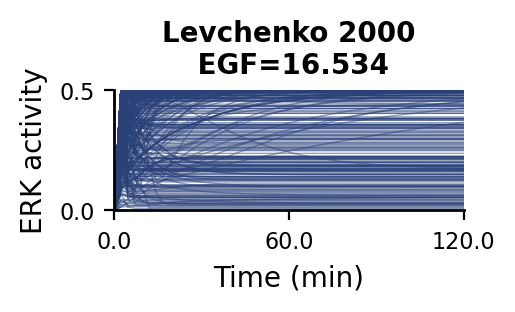

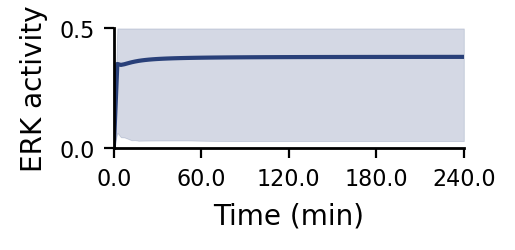

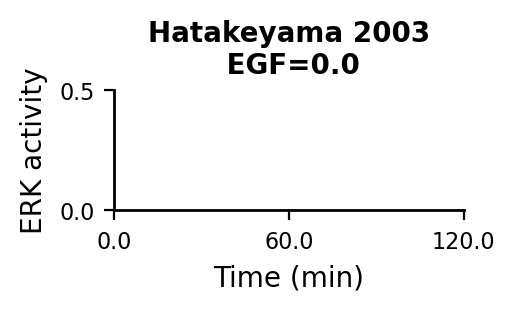

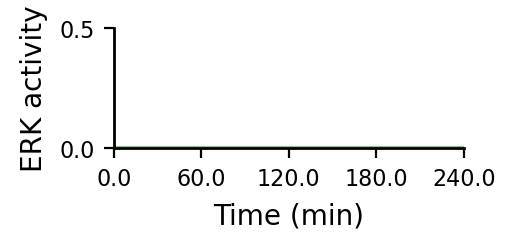

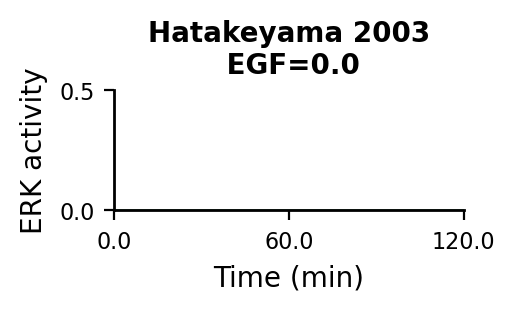

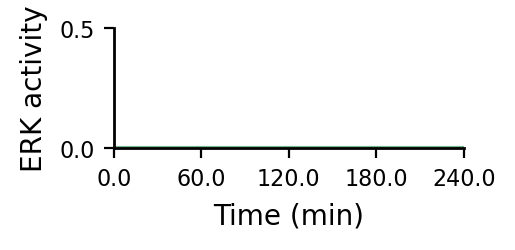

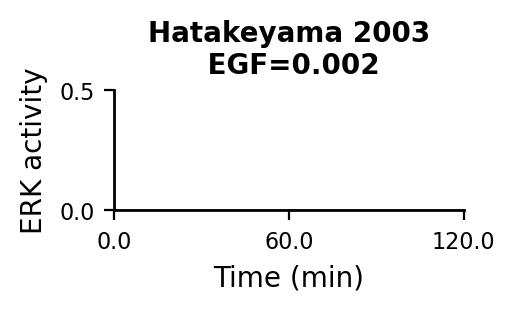

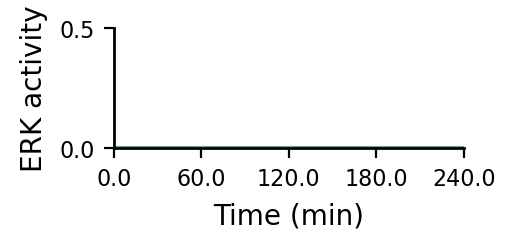

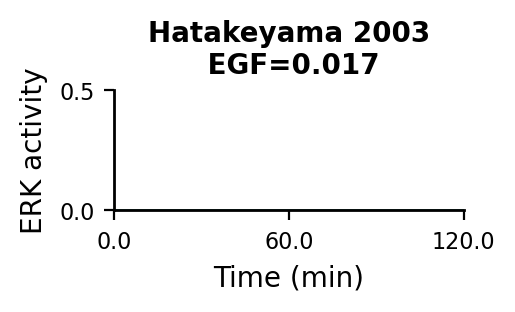

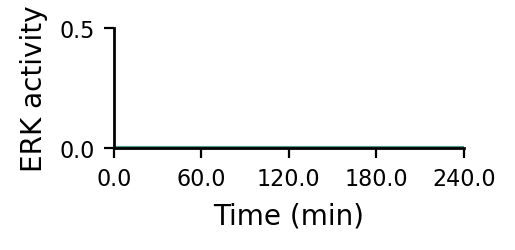

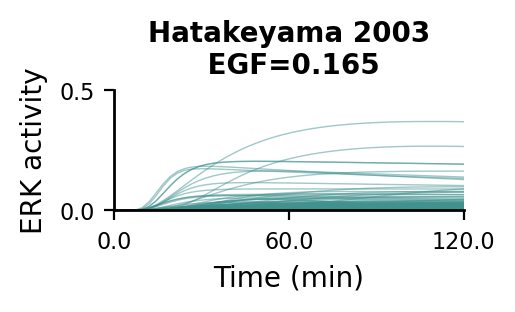

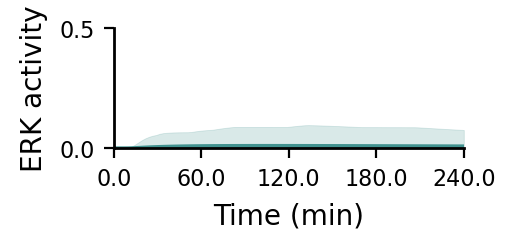

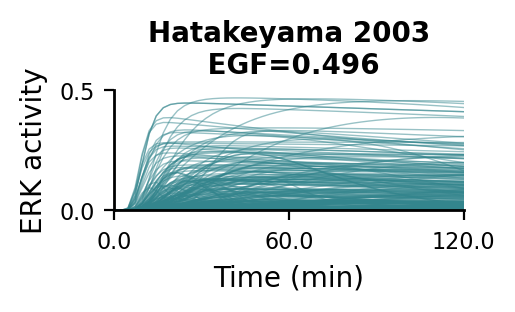

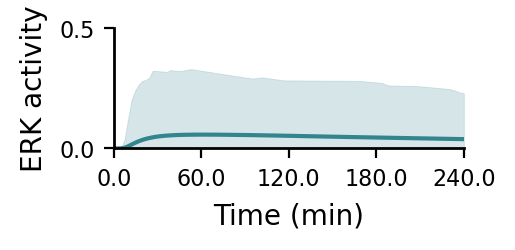

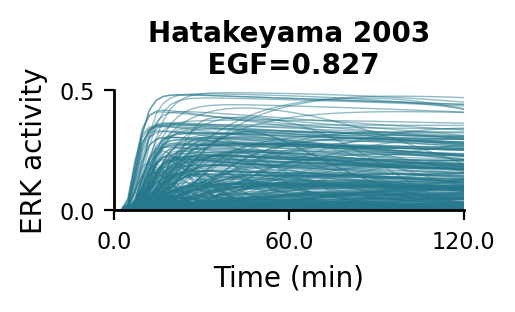

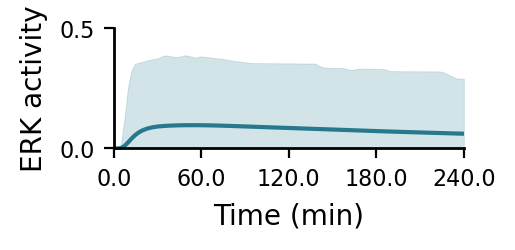

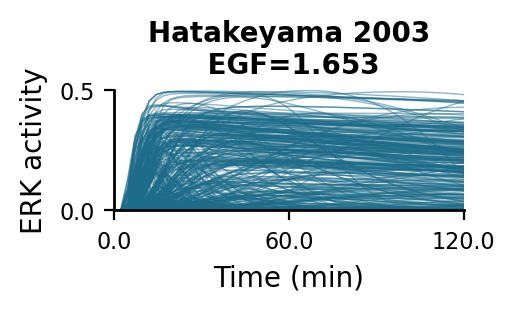

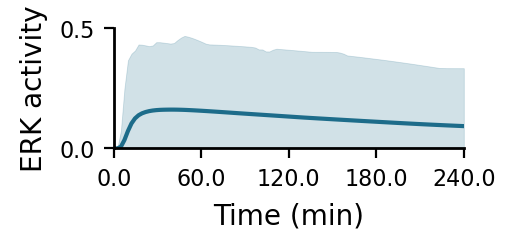

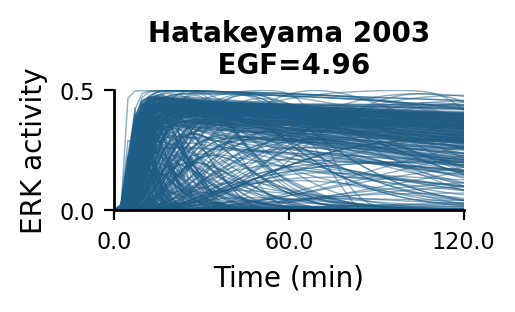

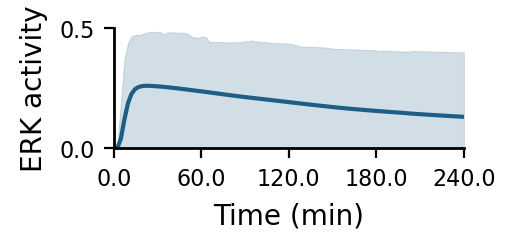

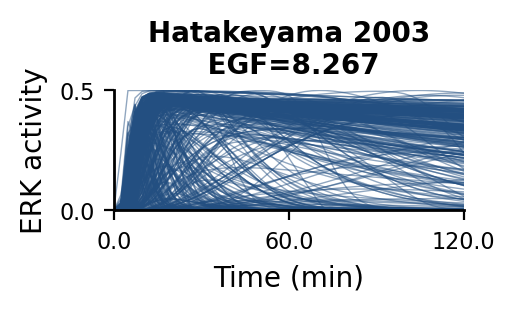

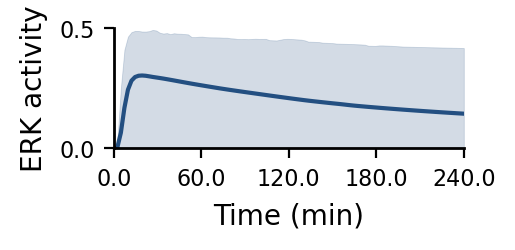

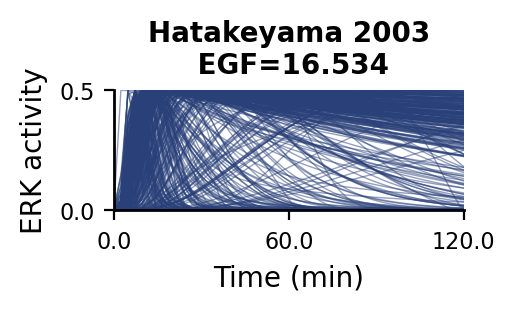

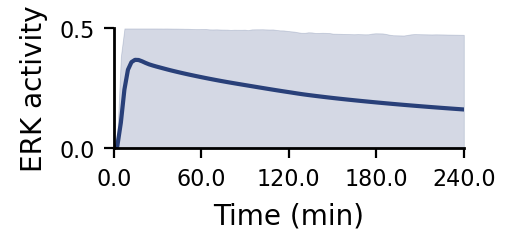

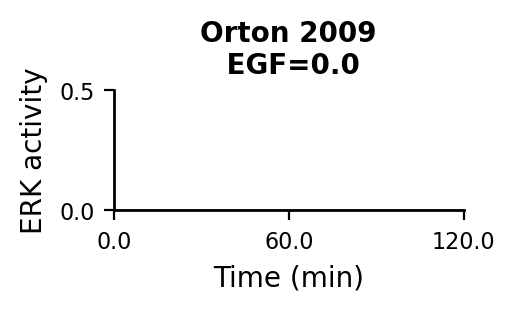

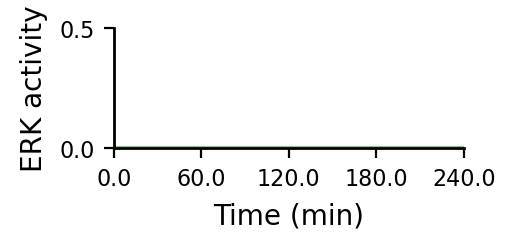

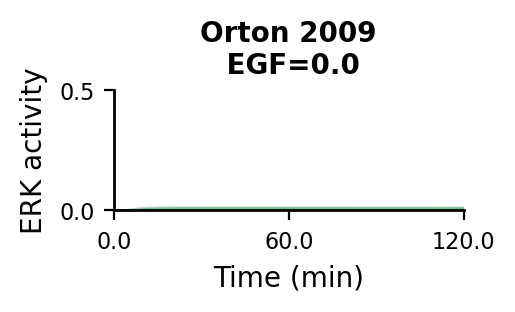

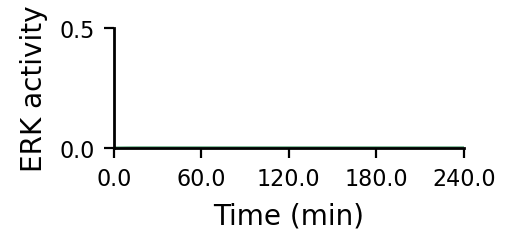

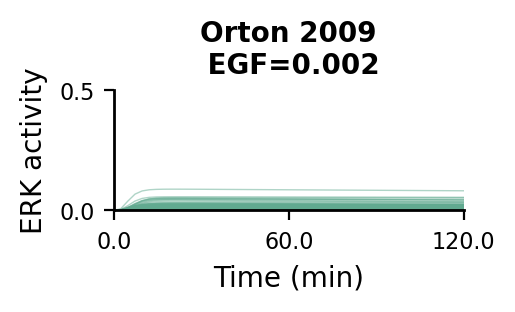

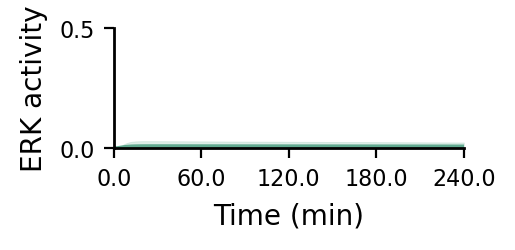

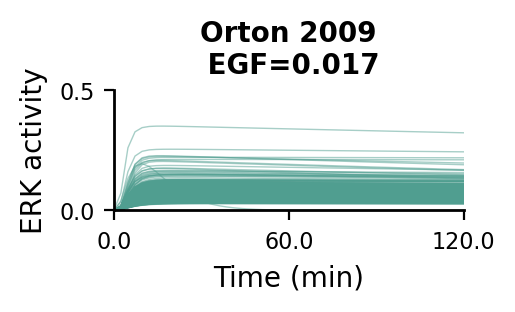

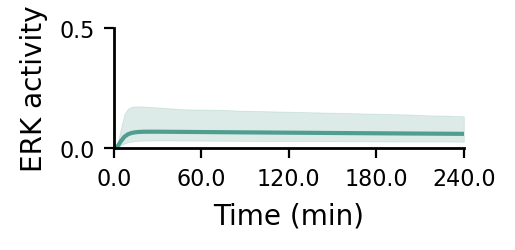

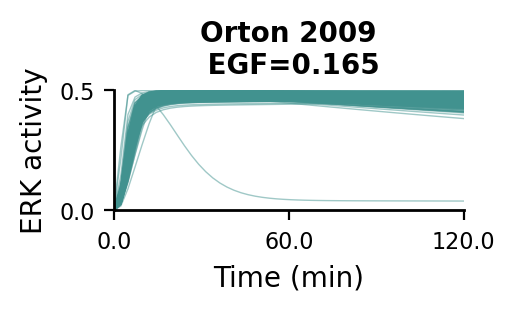

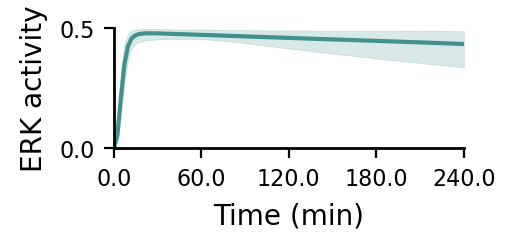

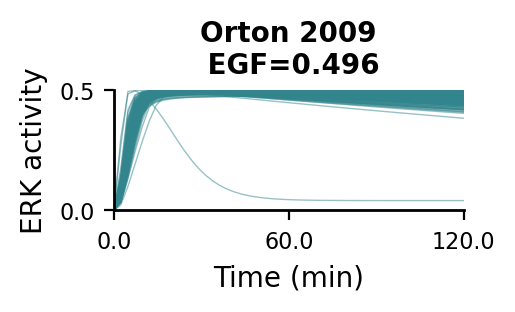

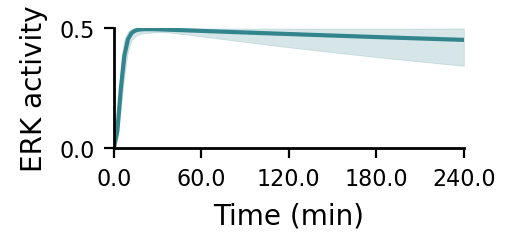

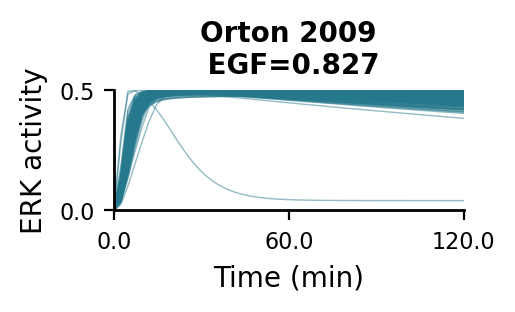

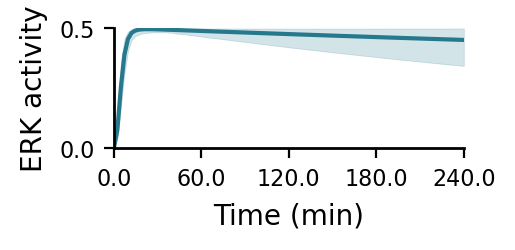

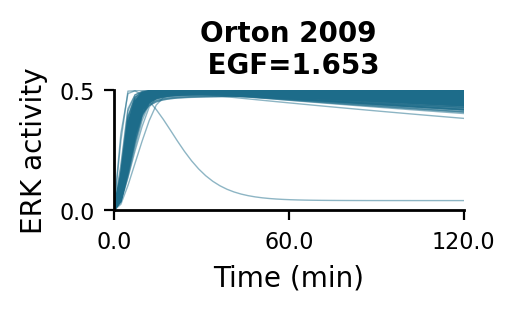

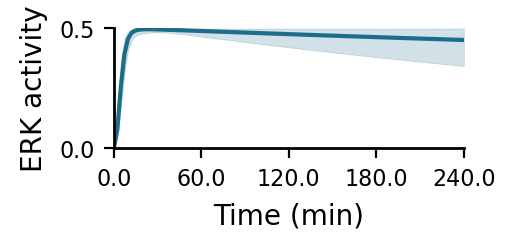

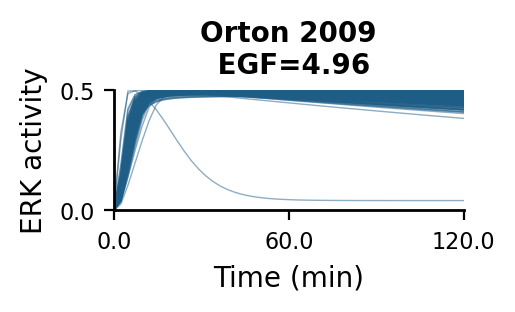

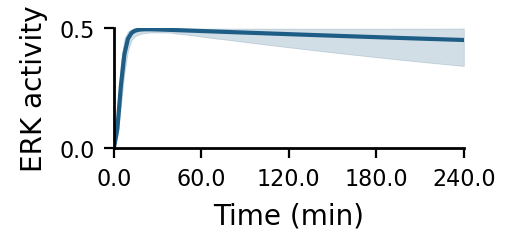

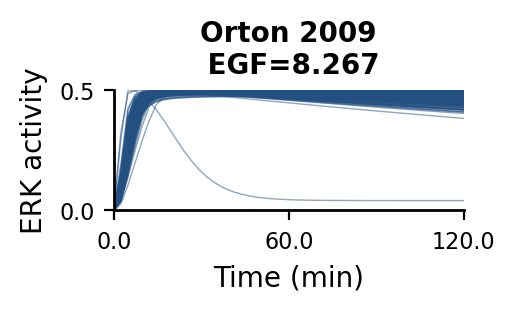

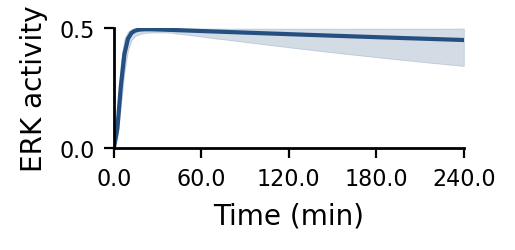

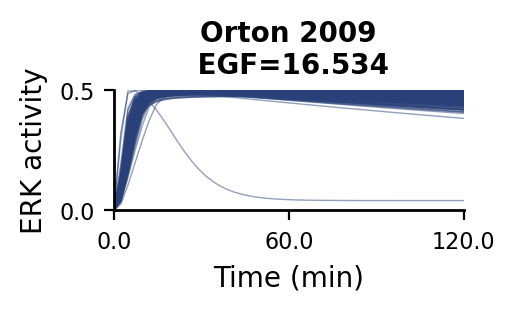

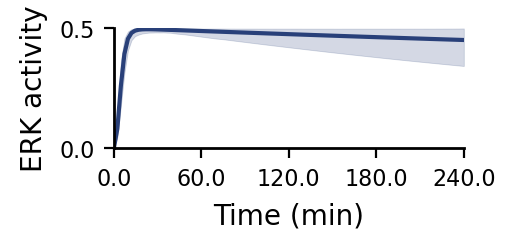

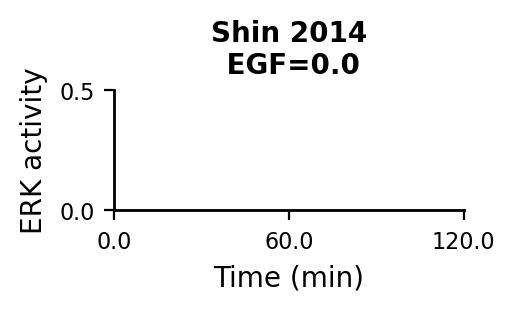

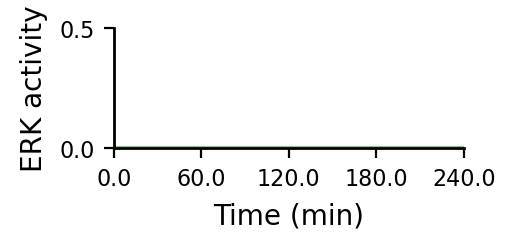

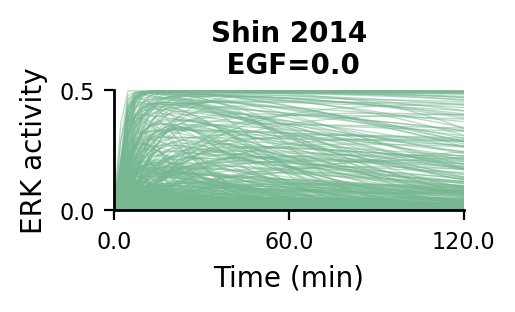

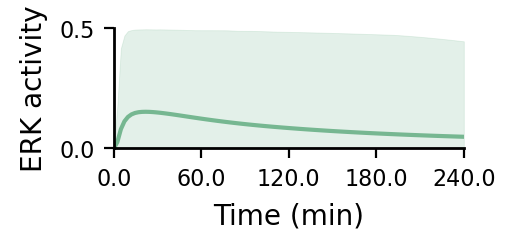

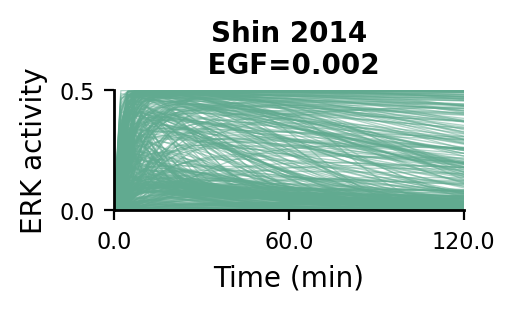

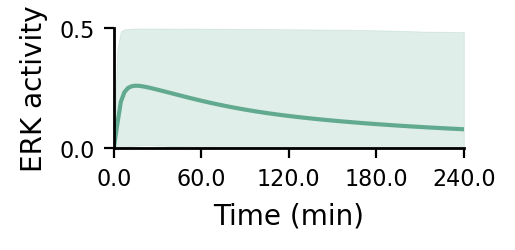

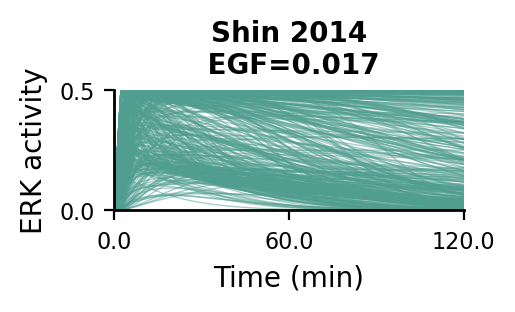

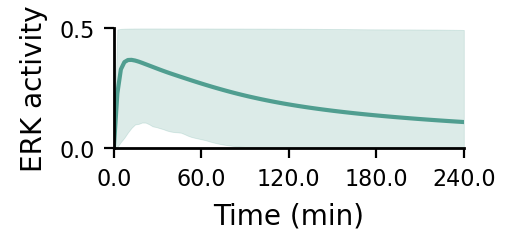

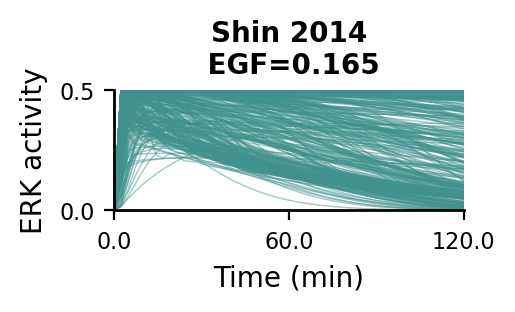

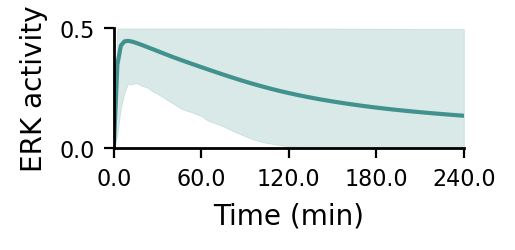

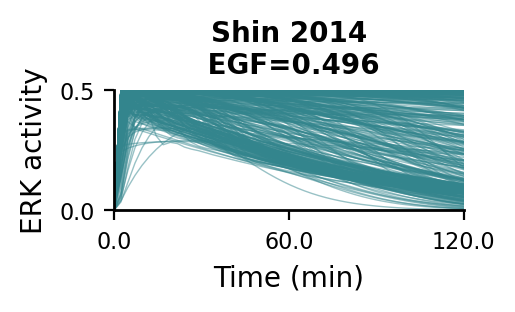

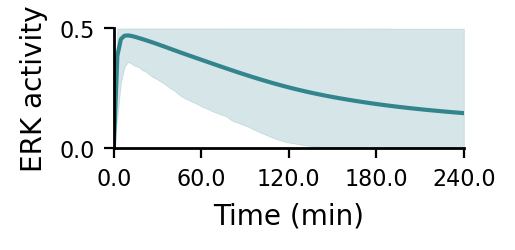

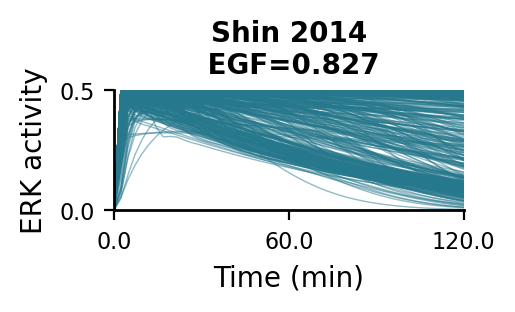

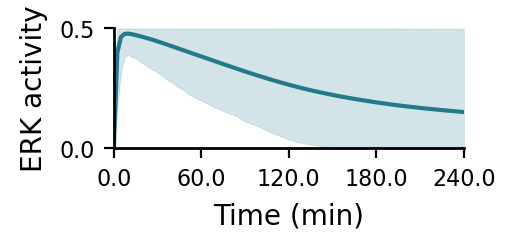

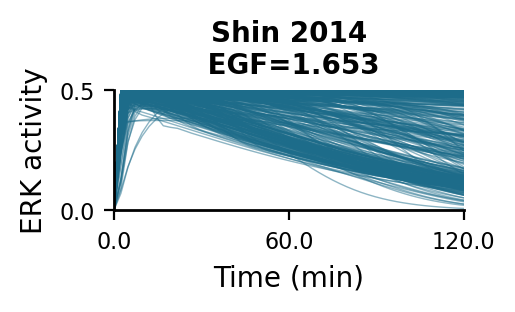

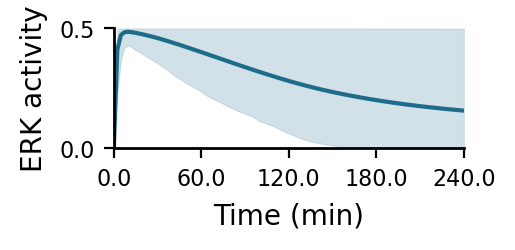

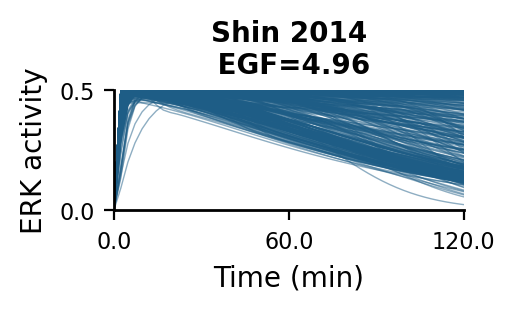

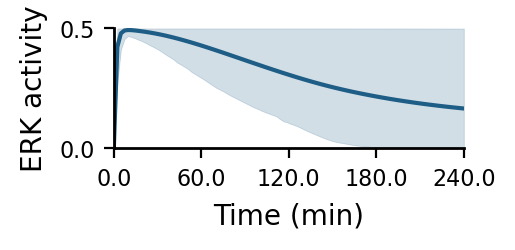

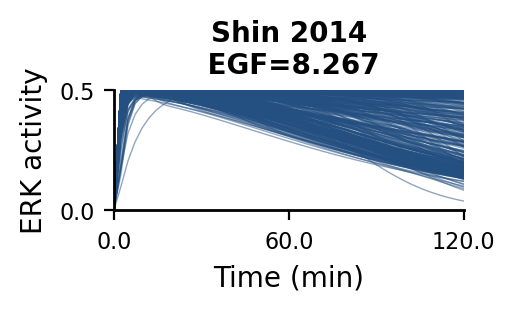

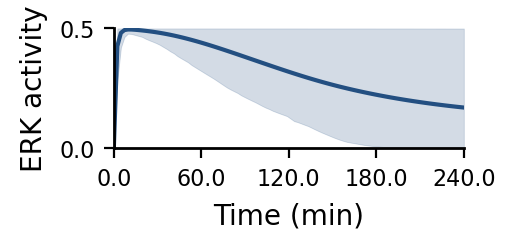

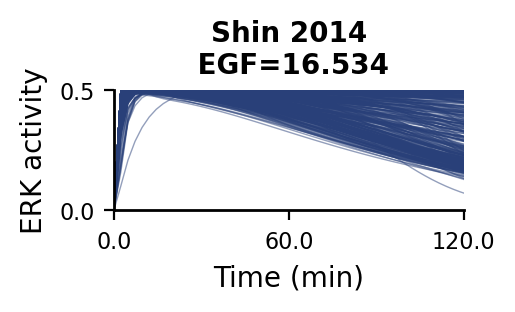

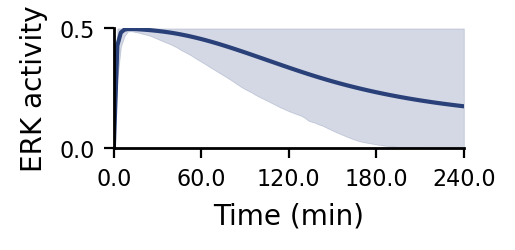

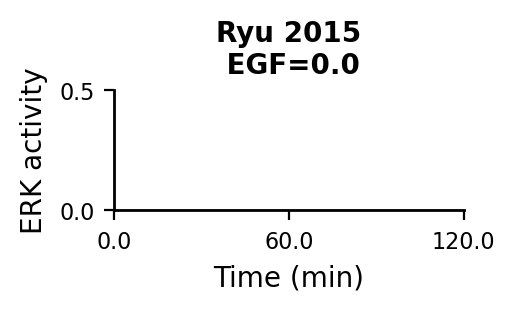

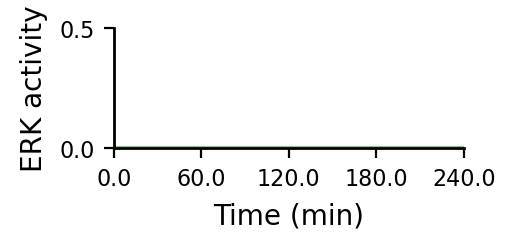

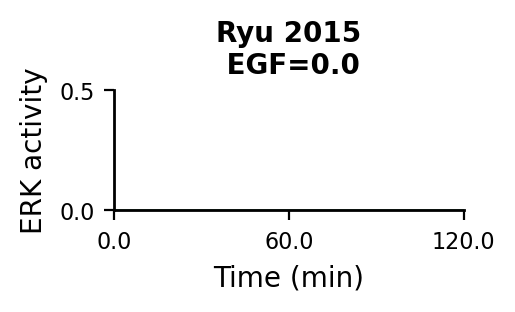

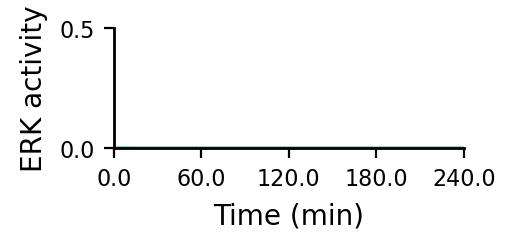

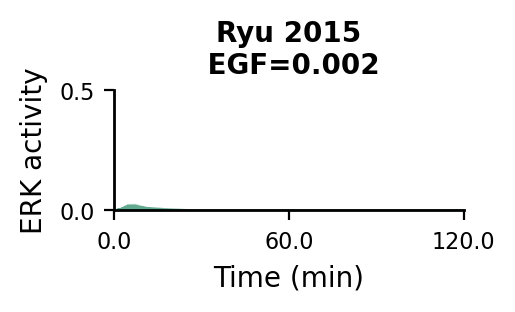

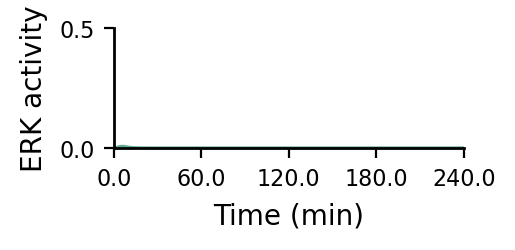

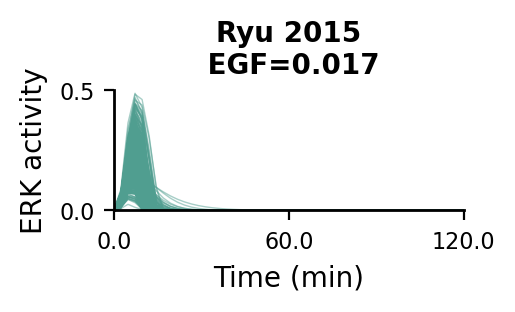

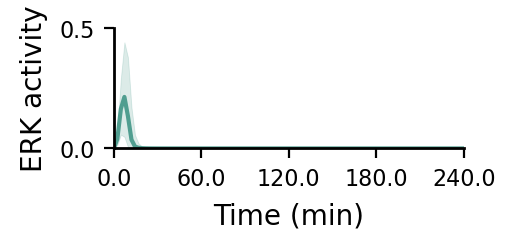

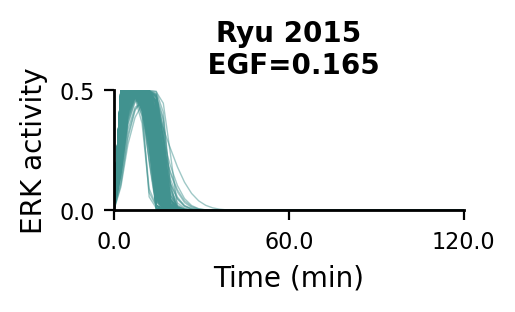

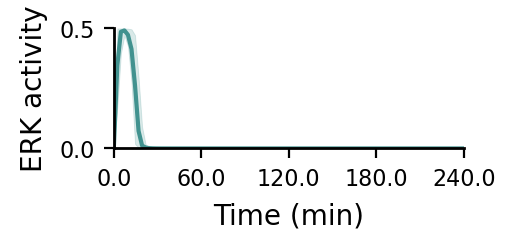

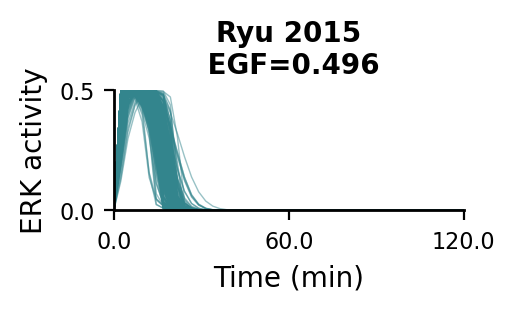

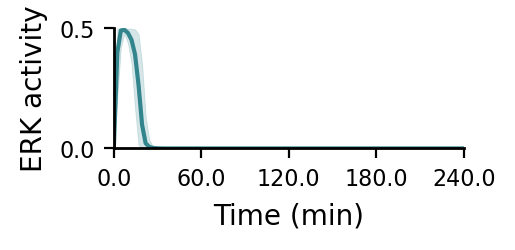

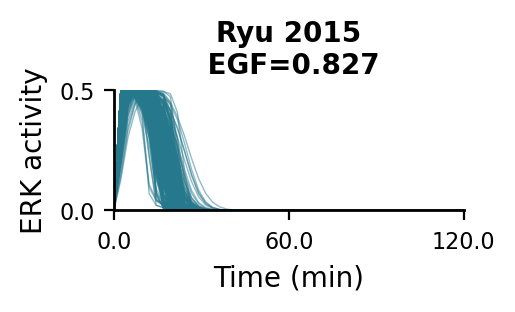

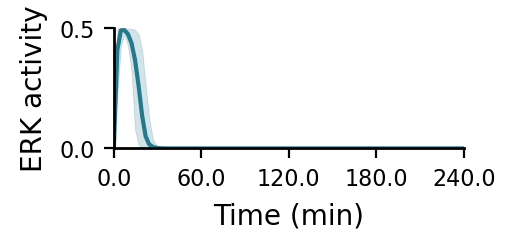

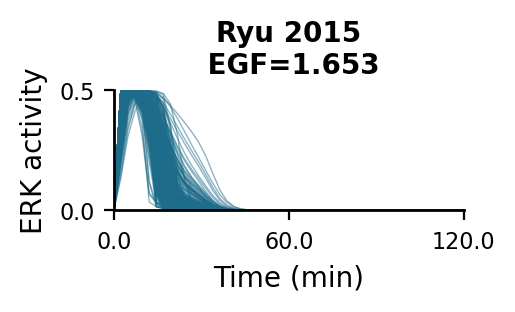

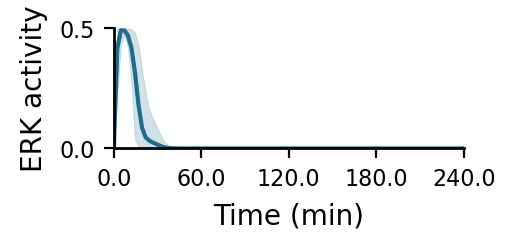

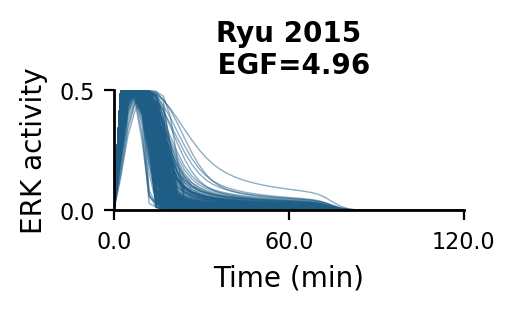

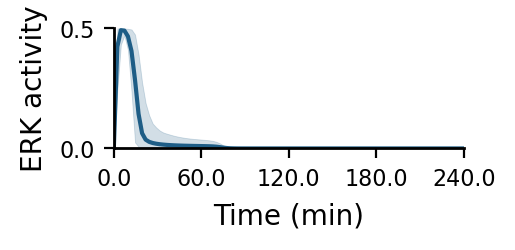

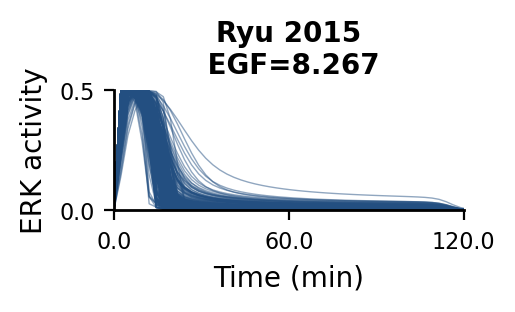

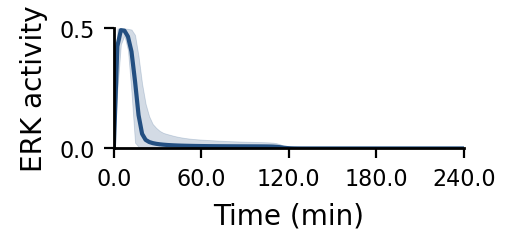

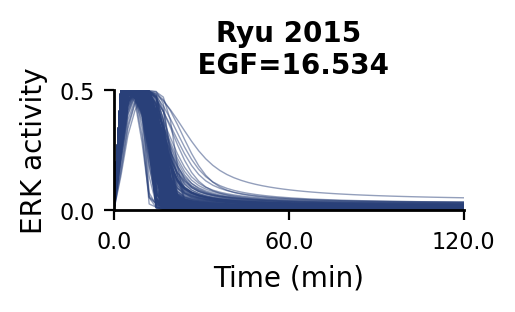

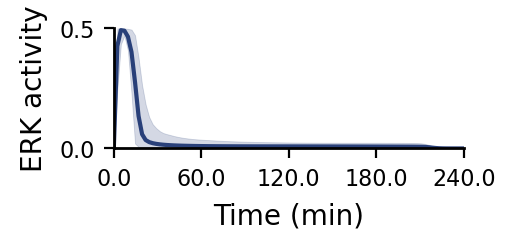

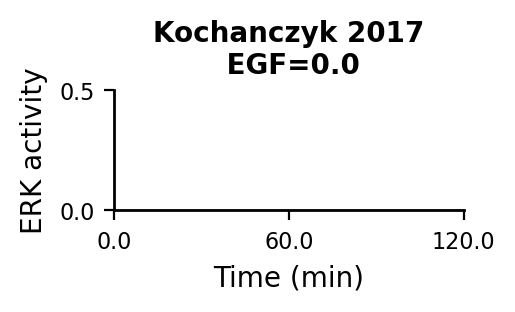

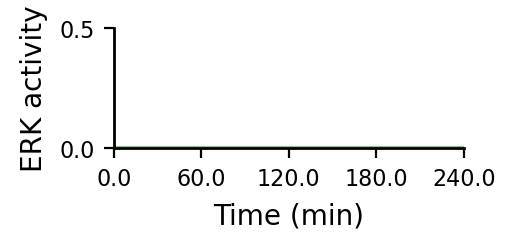

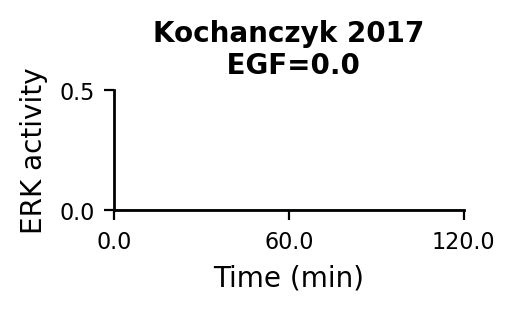

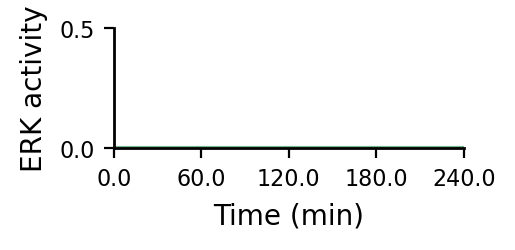

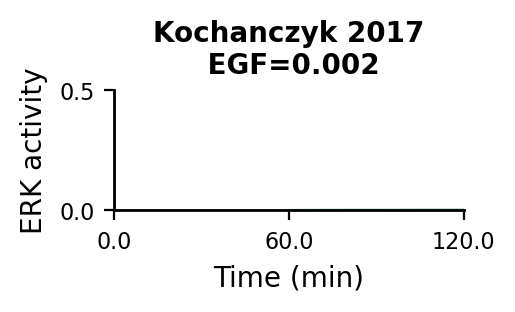

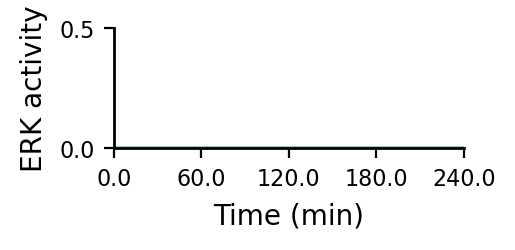

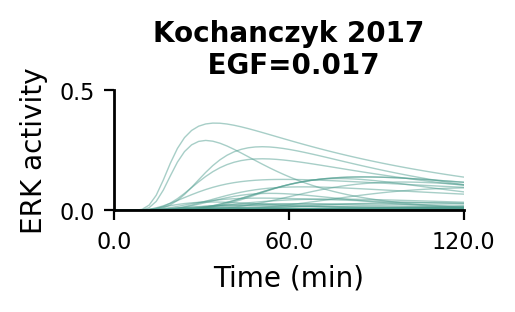

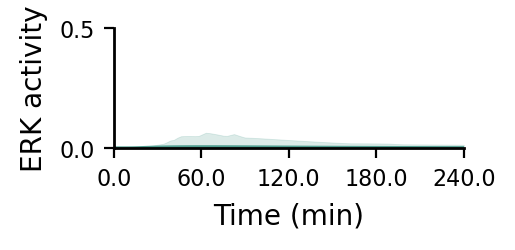

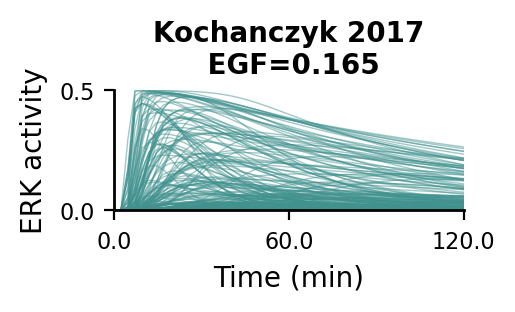

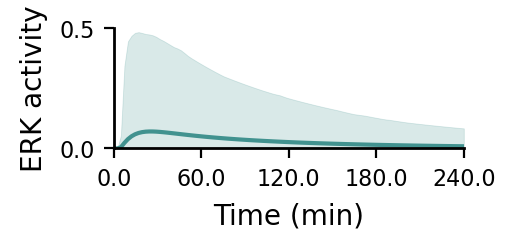

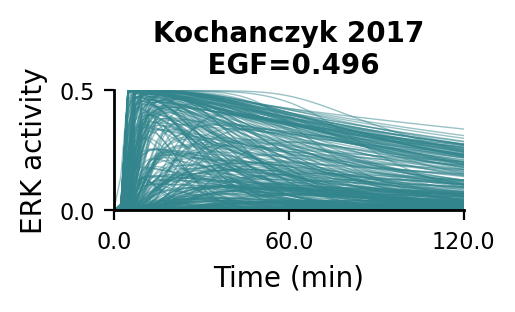

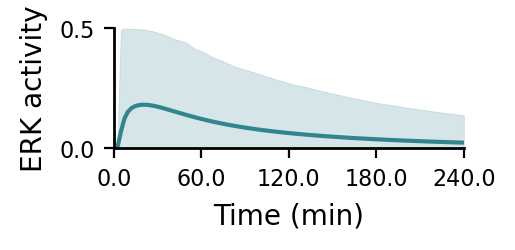

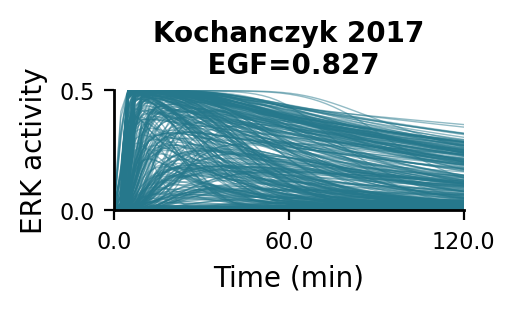

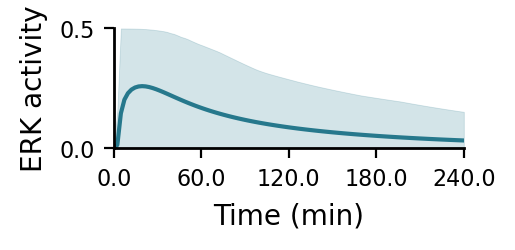

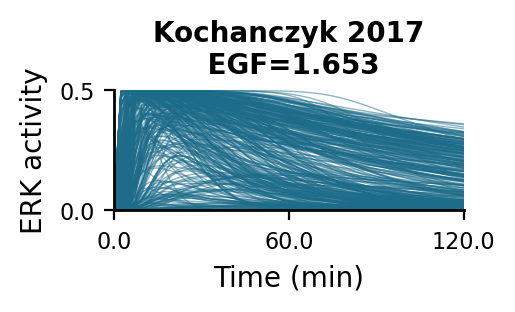

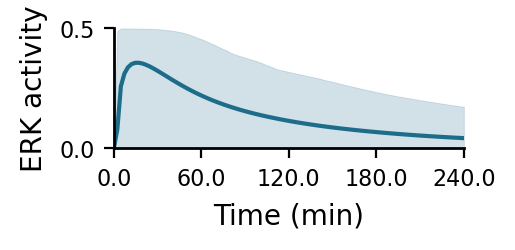

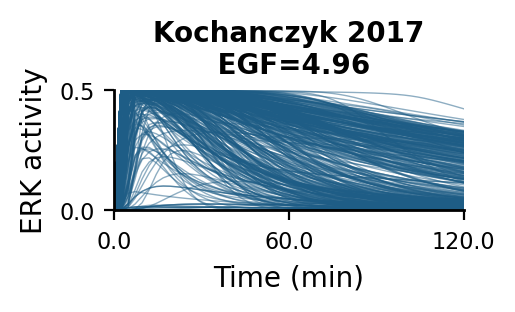

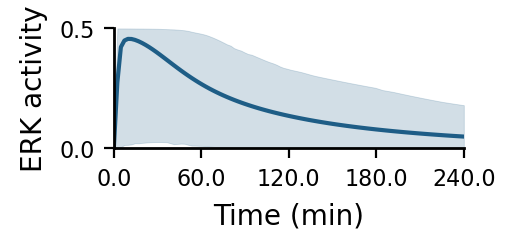

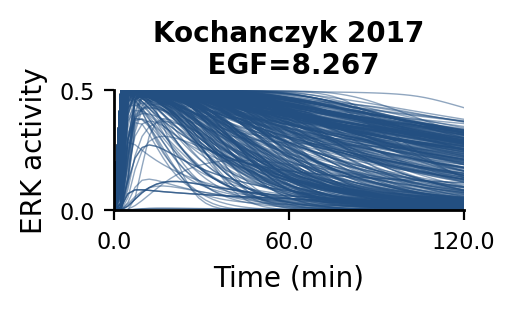

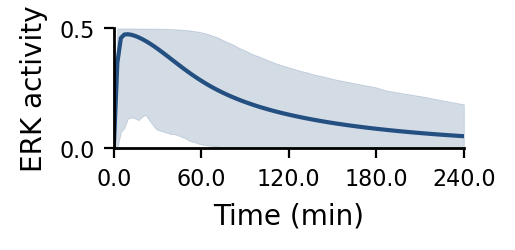

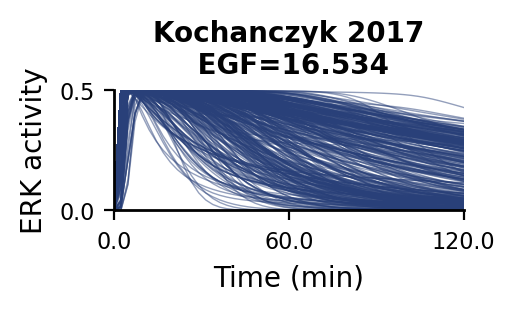

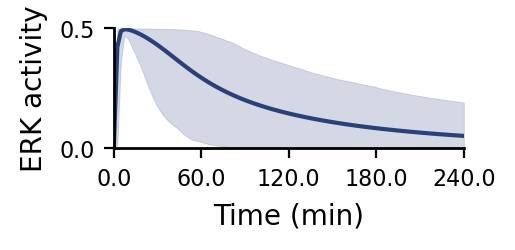

In [ ]:
# Haung and Ferrell 1996
HF_1996_conv = np.tile(np.max(np.array([np.max(HF_1996_traj[key], axis=1) for key in HF_1996_traj.keys()]), axis=0), (100,1)).T
HF_1996_traj_norm = normalize_trajs(HF_1996_traj, HF_1996_conv, 'haung_ferrell_1996', data_savedir, additional_naming='transient_')
make_traj_plots('HF_1996', 'Haung and Ferrell 1996', inputs[input_idxs], 400, HF_1996_traj_norm, HF_1996_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
plt.close('all')

# # Kholodenko 2000
# K_2000_conv = np.tile(np.max(np.array([np.max(K_2000_traj[key], axis=1) for key in K_2000_traj.keys()]), axis=0), (100,1)).T
# K_2000_traj_norm = normalize_trajs(K_2000_traj, K_2000_conv, 'kholodenko_2000', data_savedir, additional_naming='transient_')
# make_traj_plots('K_2000', 'Kholodenko 2000', inputs[input_idxs], 400, K_2000_traj_norm, K_2000_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# #plt.close('all')

# # Levchenko 2000
# L_2000_conv = np.tile(np.max(np.array([np.max(L_2000_traj[key], axis=1) for key in L_2000_traj.keys()]), axis=0), (100,1)).T
# L_2000_traj_norm = normalize_trajs(L_2000_traj, L_2000_conv, 'levchenko_2000', data_savedir, additional_naming='transient_')
# make_traj_plots('L_2000', 'Levchenko 2000', inputs[input_idxs], 400, L_2000_traj_norm, L_2000_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# #plt.close('all')

# # Hatakeyama 2003
# HK_2003_conv = np.tile(np.max(np.array([np.max(HK_2003_traj[key], axis=1) for key in HK_2003_traj.keys()]), axis=0), (100,1)).T
# HK_2003_traj_norm = normalize_trajs(HK_2003_traj, HK_2003_conv, 'hatakeyama_2003', data_savedir, additional_naming='transient_')
# make_traj_plots('HK_2003', 'Hatakeyama 2003', inputs[input_idxs], 400,  HK_2003_traj_norm, HK_2003_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# #plt.close('all')

# # # Hornberg 2005
# # H_2005_conv = np.tile(np.max(np.array([np.max(H_2005_traj[key], axis=1) for key in H_2005_traj.keys()]), axis=0), (100,1)).T
# # H_2005_traj_norm = normalize_trajs(H_2005_traj, H_2005_conv, 'hornberg_2005', data_savedir, additional_naming='transient_')
# # make_traj_plots('H_2005', 'Hornberg 2005', inputs[input_idxs], 400,H_2005_traj_norm, H_2005_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# # #plt.close('all')

# # # Birtwistle 2007
# # B_2007_conv = np.tile(np.max(np.array([np.max(B_2007_traj[key], axis=1) for key in B_2007_traj.keys()]), axis=0), (100,1)).T
# # B_2007_traj_norm = normalize_trajs(B_2007_traj, B_2007_conv, 'birtwistle_2007', data_savedir, additional_naming='transient_')
# # make_traj_plots('B_2007', 'Birtwistle 2007', inputs[input_idxs], 400,  B_2007_traj_norm, B_2007_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# # #plt.close('all')

# # Orton 2009
# O_2009_conv = np.tile(np.max(np.array([np.max(O_2009_traj[key], axis=1) for key in O_2009_traj.keys()]), axis=0), (100,1)).T
# O_2009_traj_norm = normalize_trajs(O_2009_traj, O_2009_conv, 'orton_2009', data_savedir, additional_naming='transient_')
# make_traj_plots('O_2009', 'Orton 2009', inputs[input_idxs], 400, O_2009_traj_norm, O_2009_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# #plt.close('all')

# # # vonKriegsheim 2009
# ## VK_2009_conv = np.array(0.0311267292018+0.9688732707982)
# ## make_traj_plots('VK_2009', 'vonKriegsheim 2009', inputs[input_idxs], 400, VK_2009_traj, VK_2009_converted_times, fig_savedir, , [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# #plt.close('all')

# # Shin 2014
# S_2014_conv = np.tile(np.max(np.array([np.max(S_2014_traj[key], axis=1) for key in S_2014_traj.keys()]), axis=0), (100,1)).T
# S_2014_traj_norm = normalize_trajs(S_2014_traj, S_2014_conv, 'shin_2014', data_savedir, additional_naming='transient_')
# make_traj_plots('S_2014', 'Shin 2014', inputs[input_idxs], 400, S_2014_traj_norm, S_2014_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# # #plt.close('all')

# # Ryu 2015
# R_2015_conv = np.tile(np.max(np.array([np.max(R_2015_traj[key], axis=1) for key in R_2015_traj.keys()]), axis=0), (100,1)).T
# R_2015_traj_norm = normalize_trajs(R_2015_traj, R_2015_conv, 'ryu_2015', data_savedir, additional_naming='transient_')
# make_traj_plots('R_2015', 'Ryu 2015', inputs[input_idxs], 400, R_2015_traj_norm, R_2015_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# # plt.close('all')

# # Kochanczyk 2017
# K_2017_conv = np.tile(np.max(np.array([np.max(K_2017_traj[key], axis=1) for key in K_2017_traj.keys()]), axis=0), (100,1)).T
# K_2017_traj_norm = normalize_trajs(K_2017_traj, K_2017_conv, 'kochanczyk_2017', data_savedir, additional_naming='transient_')
# make_traj_plots('K_2017', 'Kochanczyk 2017', inputs[input_idxs], 400, K_2017_traj_norm, K_2017_converted_times, fig_savedir, [np.nan]*len(input_idxs), np.nan, additional_naming='transient_', traj_plot_height=0.6)
# # plt.close('all')